In [97]:
# import some library that we will use
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as pylab
import seaborn as sns
from urllib.parse import urlparse,urlencode
import urllib
import ipaddress
import re
import whois
import warnings
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)

In [2]:
df= pd.read_csv(r'C:\Users\mahmoud\Downloads\train\zomato.csv')
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [3]:
df.shape

(51717, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [5]:
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


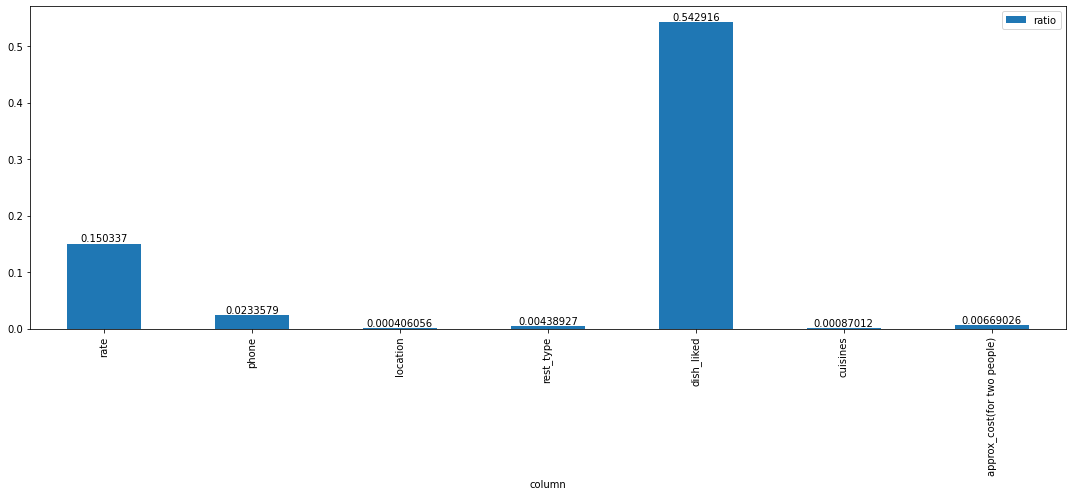

In [6]:
# null ratio in our data
def null_ratio(df):
    data=[(col, df[col].isnull().sum()/len(df))
           for col in df.columns if df[col].isnull().sum()>0]
    columns=['column', 'ratio']
    missing_data= pd.DataFrame(data, columns=columns)
    pylab.rcParams["figure.figsize"]=(15,7)
    ax=missing_data.plot(kind="bar",x="column", y='ratio')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()

null_ratio(df)

In [7]:
# since the menu item column have more than 70% empty value we will droped
df.loc[df['menu_item'] == "[]" ].count()[0]/len(df)

0.7660343794110254

In [8]:
# droping low ratio null value and delete unnecessary columns
def drop_n(df):
    df.dropna(subset=['location','rest_type','cuisines','approx_cost(for two people)'],inplace=True)
    df.drop(['phone','menu_item','dish_liked'], axis=1, inplace=True)
    df.reset_index()
drop_n(df) 

In [9]:
df.isnull().sum()

url                               0
address                           0
name                              0
online_order                      0
book_table                        0
rate                           7615
votes                             0
location                          0
rest_type                         0
cuisines                          0
approx_cost(for two people)       0
reviews_list                      0
listed_in(type)                   0
listed_in(city)                   0
dtype: int64

In [10]:
# this function to clean the review column so we can take the nmber of rated value.
def split_(h):
    spli1= h.split(',')[0]
    stri1= spli1.strip('[(')
    spli2= stri1.split(' ')[-1]
    stri2= spli2.strip("'")
    return stri2

In [11]:
# apply the function.
df['review']= df['reviews_list'].apply(lambda x: split_(x))

In [12]:
df['review'].unique()

array(['4.0', '3.0', '5.0', '1.0', '2.0', '1.5', ']', '3.5', '4.5', '2.5'],
      dtype=object)

In [13]:
# replacing the symples and the empty columns
df['review']= np.where(df['review'] == ']', np.nan, df['review'])

In [14]:
# fill the null value in column rate with values from review colum.
df['rate']= np.where(df['rate'].isnull(), df['review'], df['rate'])

In [15]:
df['rate'].value_counts()

NEW       2205
3.9/5     2091
3.7/5     2008
3.8/5     1999
3.9 /5    1867
          ... 
2.2 /5       7
2.0 /5       7
2.0/5        4
1.8 /5       3
1.8/5        2
Name: rate, Length: 73, dtype: int64

In [16]:
# after replacing the null value in rate with review it seems that review values is not enough for 
# that we calculated another rate values using votes column
df['calc_rate']= df['votes'].apply(lambda x: x/len(df['votes'])*100/2)

In [17]:
df['rate']= np.where(df['rate'].isnull(), df['calc_rate'], df['rate'])

In [18]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '4.0', '1.0', 0.0, '2.6/5',
       '3.8 /5', '3.4/5', '5.0', '4.5/5', '2.5/5', '3.0', '2.7/5', '3.5',
       '4.7/5', '2.4/5', '2.2/5', '4.5', '2.3/5', '2.0', '3.4 /5', '-',
       '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5', '4.1 /5',
       '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5', '3.5 /5',
       '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5', '4.3 /5',
       '4.4 /5', '4.9/5', '1.5', '2.1/5', '2.5', '2.0/5', '1.8/5',
       '4.6 /5', '4.9 /5', '3.0 /5', 0.27664815828575895,
       0.16325174004848675, 0.005865331977789942, 0.003910221318526629,
       '4.8 /5', 0.004887776648158286, 0.12903730351137874, '2.3 /5',
       '4.7 /5', '2.4 /5', '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'],
      dtype=object)

In [19]:
# spliting the rate column to values 1 and 0 using 3.7 as ratio 1 for high rated 0 for low rated resturant.
def rate_(col):
    df['new_rate']= df[col].apply(lambda x: str(x).split('/')[0])
    df['new_rate']=df['new_rate'].replace(['NEW','-',''],0)
    df['rate_1']= df['new_rate'].astype(float)
    
    def rate(r):
        if r >= 3.7:
            return 1
        else:
            return 0
        
    df['rate_1']= df['rate_1'].apply(lambda x: rate(x))
    
rate_('rate')

In [20]:
df['rate_1'].value_counts()

0    26023
1    25125
Name: rate_1, dtype: int64

In [21]:
df['cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ...,
       'North Indian, Street Food, Biryani', 'Chinese, Mughlai',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [22]:
# categories the cuisines column to 7 categorie.
df['cuisines'] = pd.np.where(df.cuisines.str.contains("Indian","Biryani"),'Indian',
                               pd.np.where(df.cuisines.str.contains("Cafe","Pizza"),'Italian',
                               pd.np.where(df.cuisines.str.contains("Desserts","Beverages"),'Desserts',
                               pd.np.where(df.cuisines.str.contains("Chinese"),'Chinese',
                               pd.np.where(df.cuisines.str.contains("Thai"),'Thai',
                               pd.np.where(df.cuisines.str.contains("Bakery"),'Desserts',
                               pd.np.where(df.cuisines.str.contains("Food","Burger"),'fastfood',
                               pd.np.where(df.cuisines.str.contains("sea"),'seafood', 'other'))))))))

In [23]:
# get the domain name from url.
def getDomain(url):
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
        domain = domain.replace("www.","")
    return domain

In [24]:
df['domain_name']= df['url'].apply(lambda x: getDomain(x))

In [25]:
# cheking if the url is legitimate or phishing.
df['@_sign']= ['phishing' if "@" in url else 'legitimate' for url in df['url']]

In [26]:
df['listed_in(city)'].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

In [27]:
df.location.unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Sarjapur Road', 'Whitefield', 'East Bangalore',
       'Old Airport Road', 'Indiranagar', 'Koramangala 1st Block',
       'Frazer Town', 'RT Nagar', 'MG Road', 'Brigade Road',
       'Lavelle Road', 'Church Street', 'Ulsoor', 'Residency Road',
       'Shivajinagar', 'Infantry Road', 'St. Marks Road',
       'Cunningham Road', 'Race Course Road', 'Commercial Street',
       'Vasanth Nagar', 'HBR Layout', 'Domlur', 'Ejipura',
       'Jeeva

In [28]:
df.rename({'listed_in(city)': 'city','listed_in(type)':'type'}, axis=1, inplace=True)

In [29]:
# function to check if  the serveing area for the resturant.
def area_serve(i,n):
    if i == n:
        return 1
    else:
        return len(i.split(',')) + n.count(n)

In [30]:
df['num_of_serving_area']= df.apply(lambda x: area_serve(x.city, x.location), axis=1)

In [31]:
df['address']= df['address'].apply(lambda x: x.split(',')[-2:][0])

In [32]:
# function to check if the resturant have correct address or not.
def correct_adr(y,n):
    if y.strip() == n.strip():
        return 'correct'
    else:
        return 'false'

In [33]:
df['correct_address']= df.apply(lambda x: correct_adr(x.address, x.city),axis=1)

In [34]:
# drop some unuseful columns.
df.drop(['url','address','reviews_list'],axis=1, inplace=True)

In [35]:
df.rename({'approx_cost(for two people)':'approx_cost_for_two_people'},axis=1, inplace=True)

In [36]:
# calculate the approx_cost_for_one in the resturant.
df['approx_cost_for_one']= df['approx_cost_for_two_people'].apply(lambda x: round(int(str(x).replace(",",""))/2),1)

In [37]:
df['votes']= df['votes'].astype(int).sort_values()

In [38]:
# checking if the resturant has high vote or low vote.
def vote_cat(h, ratio):
    if h <= ratio:
        return 'low vote'
    elif h > ratio:
        return 'high vote'

In [39]:
df['vote']= df['votes'].apply(lambda x: vote_cat(x, df.votes.median()))

In [40]:
df.vote.value_counts()

low vote     25639
high vote    25509
Name: vote, dtype: int64

In [41]:
df.votes.describe()

count    51148.000000
mean       284.917885
std        806.495210
min          0.000000
25%          7.000000
50%         41.000000
75%        199.000000
max      16832.000000
Name: votes, dtype: float64

In [42]:
df[df['review'].isnull()]

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost_for_two_people,type,city,review,calc_rate,new_rate,rate_1,domain_name,@_sign,num_of_serving_area,correct_address,approx_cost_for_one,vote
75,Om Sri Vinayaka Chats,No,No,NEW,0,Banashankari,"Takeaway, Delivery",fastfood,500,Delivery,Banashankari,NaN,0.000000,0,0,zomato.com,legitimate,1,correct,250,low vote
91,Sunsadm,No,No,0.0,0,Banashankari,"Takeaway, Delivery",Indian,400,Delivery,Banashankari,NaN,0.000000,0.0,0,zomato.com,legitimate,1,correct,200,low vote
92,Annapooraneshwari Mess,No,No,0.0,0,Banashankari,Mess,Indian,200,Delivery,Banashankari,NaN,0.000000,0.0,0,zomato.com,legitimate,1,correct,100,low vote
95,Vi Ra's Bar and Restaurant,No,No,3.3/5,62,Banashankari,Bar,Indian,800,Delivery,Banashankari,NaN,0.060608,3.3,0,zomato.com,legitimate,1,correct,400,high vote
107,Coffee Shopee,No,No,0.0,0,Banashankari,"Takeaway, Delivery",other,250,Delivery,Banashankari,NaN,0.000000,0.0,0,zomato.com,legitimate,1,correct,125,low vote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51643,New Ambur Biryani,No,No,0.0,0,Brookefield,Quick Bites,other,300,Dine-out,Whitefield,NaN,0.000000,0.0,0,zomato.com,legitimate,2,false,150,low vote
51644,Punjabi Thadka,No,No,0.0,0,Brookefield,Quick Bites,Indian,400,Dine-out,Whitefield,NaN,0.000000,0.0,0,zomato.com,legitimate,2,false,200,low vote
51672,Slounge - Lemon Tree Hotel,No,Yes,3.9 /5,21,Whitefield,Lounge,fastfood,"1,500",Drinks & nightlife,Whitefield,NaN,0.020529,3.9,1,zomato.com,legitimate,1,correct,750,low vote
51713,Vinod Bar And Restaurant,No,No,0.0,0,Whitefield,Bar,fastfood,600,Pubs and bars,Whitefield,NaN,0.000000,0.0,0,zomato.com,legitimate,1,correct,300,low vote


In [43]:
# impute the null value for review column.
imp= SimpleImputer(missing_values=np.nan, strategy='mean')
df['review']= imp.fit_transform(df['review'].values.reshape(-1, 1))

In [44]:
df['review']= df['review'].apply(lambda x: round(int(float(str(x).replace(",","")))),1)

In [45]:
df['type'].value_counts().nlargest(60)

Delivery              25653
Dine-out              17583
Desserts               3559
Cafes                  1703
Drinks & nightlife     1091
Buffet                  871
Pubs and bars           688
Name: type, dtype: int64

# Data Visualization

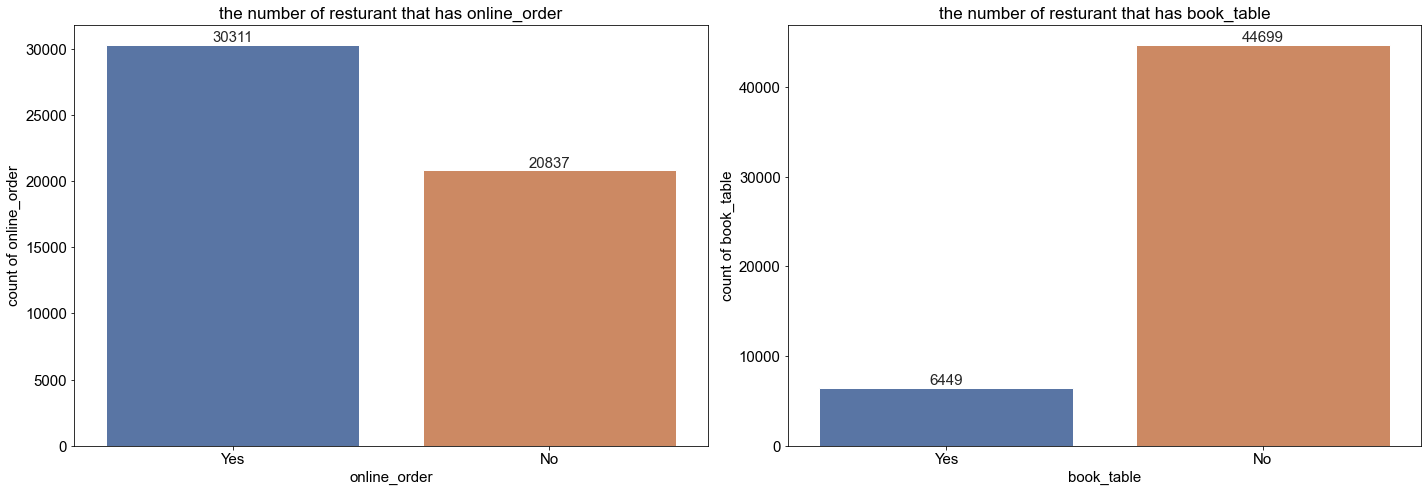

In [46]:
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.set_theme(style="whitegrid")
sns.set()

def count_plot(ax,col,df):
    
    sns.countplot(col, data=df, ax=ax)
    ax.set_title('the number of resturant that has {}'.format(col),fontsize=17)
    ax.set_ylabel('count of {}'.format(col),fontsize=15)
    ax.set_xlabel(col, fontsize=15)
    ax.bar_label(ax.containers[0], fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
count_plot(ax[0], 'online_order', df)
count_plot(ax[1], 'book_table', df)

plt.tight_layout()

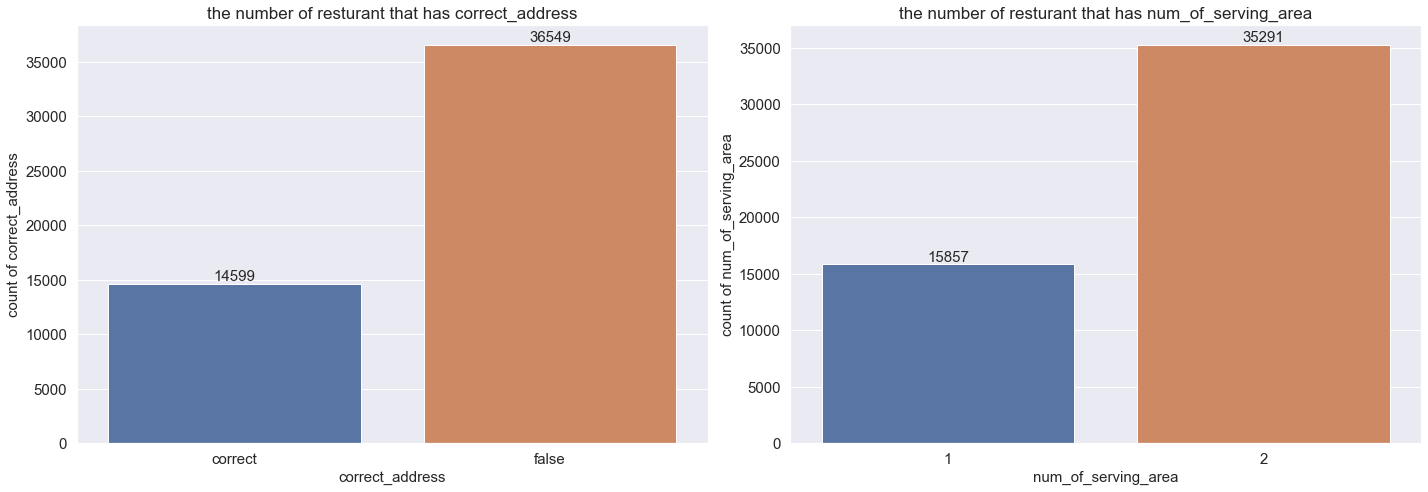

In [47]:
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(20,7))


count_plot(ax[0], 'correct_address', df)
count_plot(ax[1], 'num_of_serving_area', df)

plt.tight_layout()

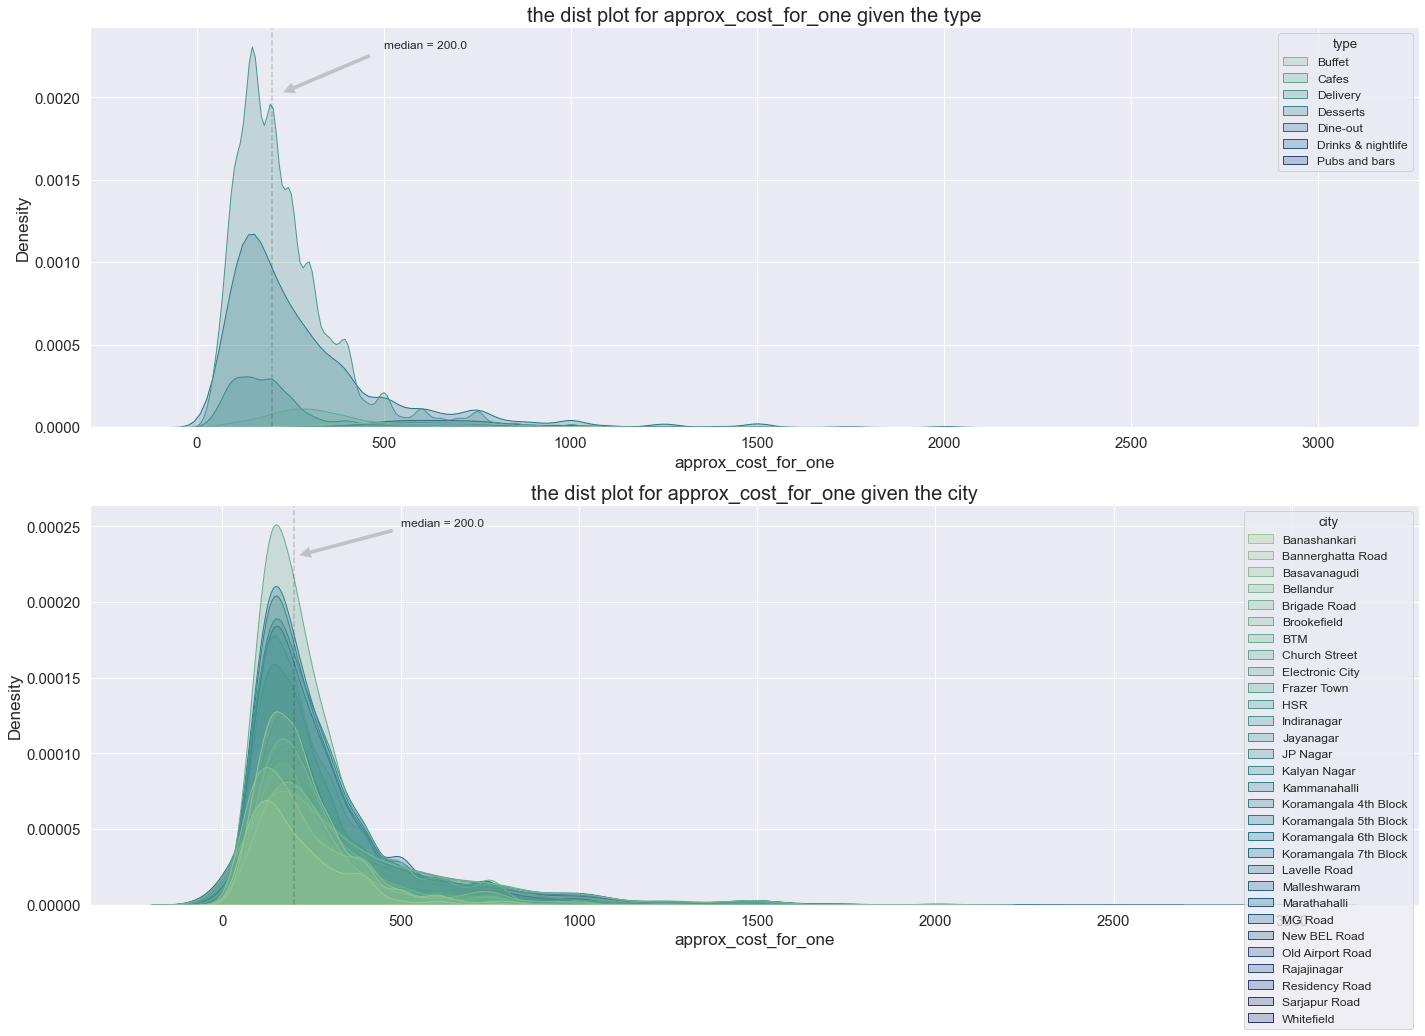

In [48]:
fig,ax= plt.subplots(nrows=2, ncols=1, figsize=(20,15))

def dist_plot(df,col,col1,ax):
    sns.set(font_scale=1.1)
    
    sns.kdeplot(
        data=df,
        x=col,
        hue=col1,
        fill=True,
        palette="crest",ax=ax)
    
    ax.set_title('the dist plot for {} given the {}'.format(col,col1),fontsize=20)
    ax.set_ylabel('Denesity',fontsize=17)
    ax.set_xlabel(col, fontsize=17)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.axvline(df[col].median(), linestyle='--', color='k', alpha=0.2, label="median")
    
    
dist_plot(df,'approx_cost_for_one','type',ax[0])
dist_plot(df,'approx_cost_for_one','city',ax[1])

ax[0].annotate('median = {}'.format(df['approx_cost_for_one'].median()), xy=(200, 0.0020), xytext=(500, 0.0023), fontsize=12,
                arrowprops=dict(facecolor='k', shrink=0.10, alpha=0.2))

ax[1].annotate('median = {}'.format(df['approx_cost_for_one'].median()), xy=(200, 0.00023), xytext=(500, 0.00025), fontsize=12,
                arrowprops=dict(facecolor='k', shrink=0.05, alpha=0.2))

plt.tight_layout()

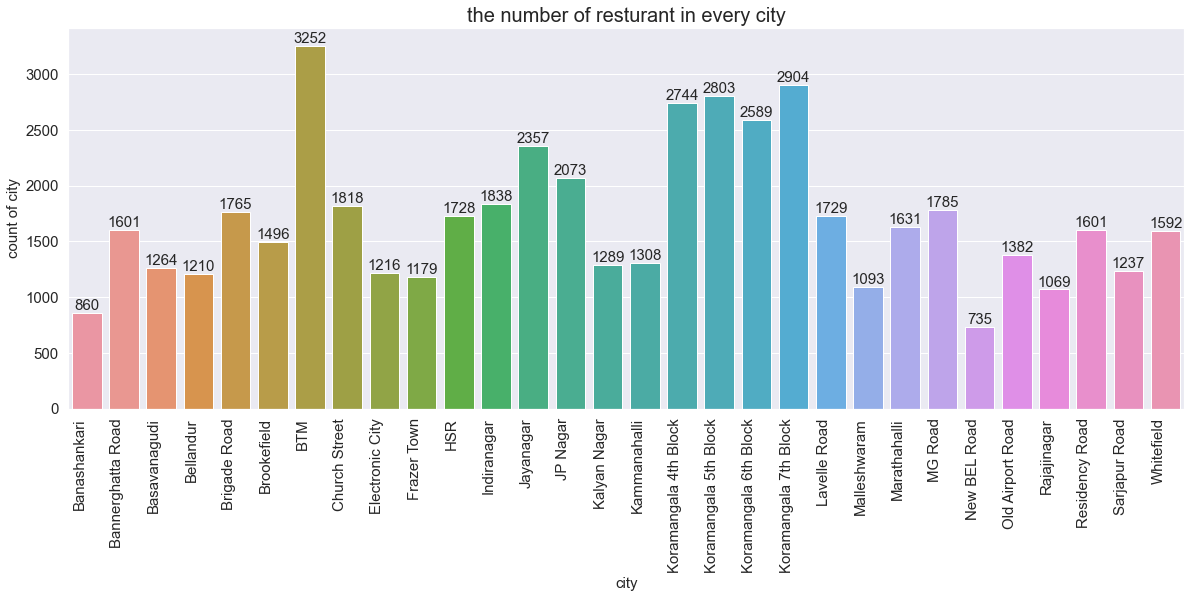

In [49]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

count_plot(ax,'city',df)
plt.xticks(rotation=90, ha='right');
plt.title('the number of resturant in every city', fontsize=20);

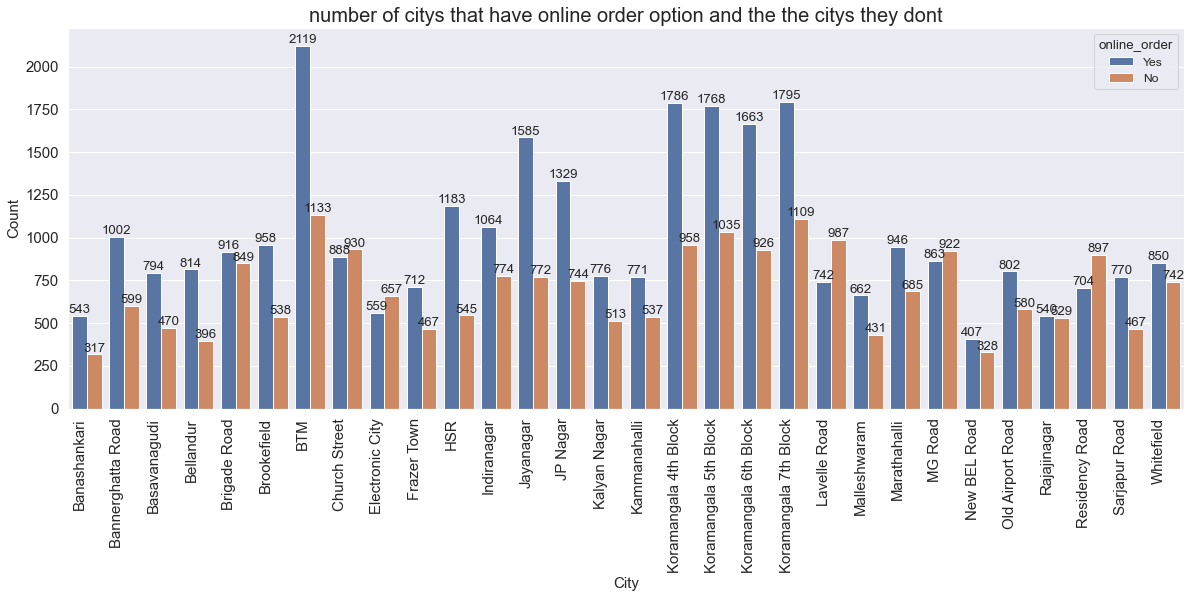

In [50]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= sns.countplot(data=df, x="city", hue="online_order")
plt.xticks(rotation=90, ha='right')
plt.title('number of citys that have online order option and the the citys they dont', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

for container in ax.containers:
    ax.bar_label(container)

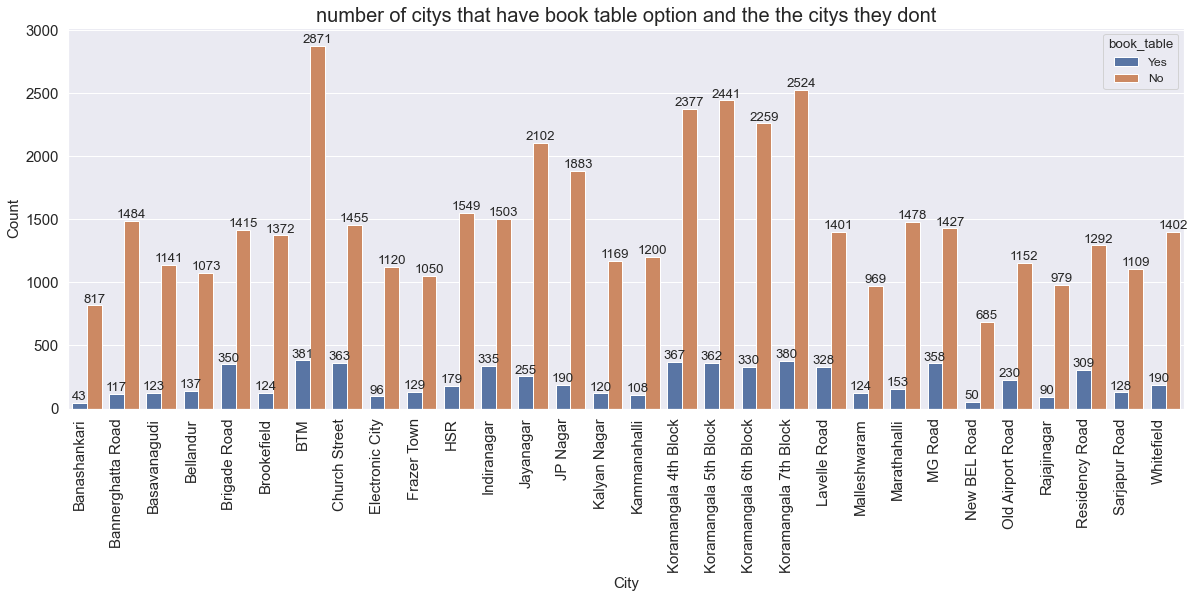

In [51]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= sns.countplot(data=df, x="city", hue="book_table")
plt.xticks(rotation=90, ha='right')
plt.title('number of citys that have book table option and the the citys they dont', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

for container in ax.containers:
    ax.bar_label(container)

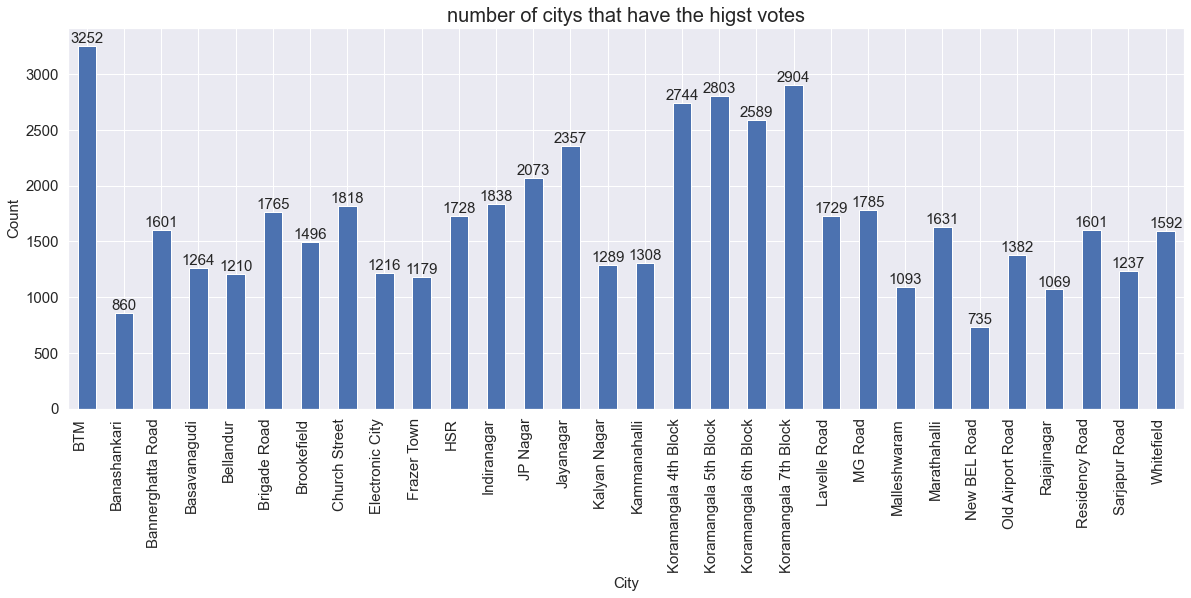

In [52]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.groupby('city')['votes'].count().plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.title('number of citys that have the higst votes', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.bar_label(ax.containers[0], fontsize=15);

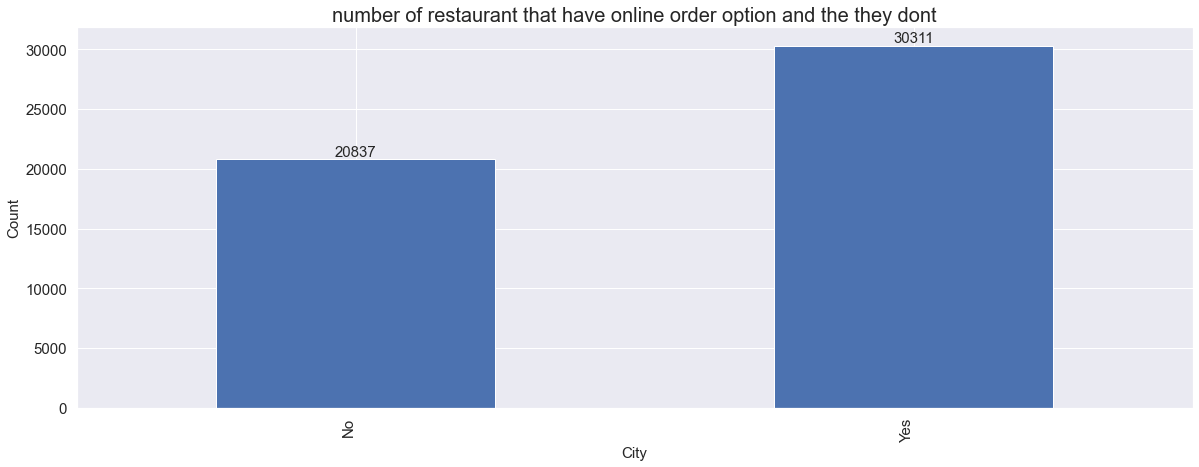

In [53]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.groupby('online_order')['name'].count().plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.title('number of restaurant that have online order option and the they dont', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.bar_label(ax.containers[0], fontsize=15);

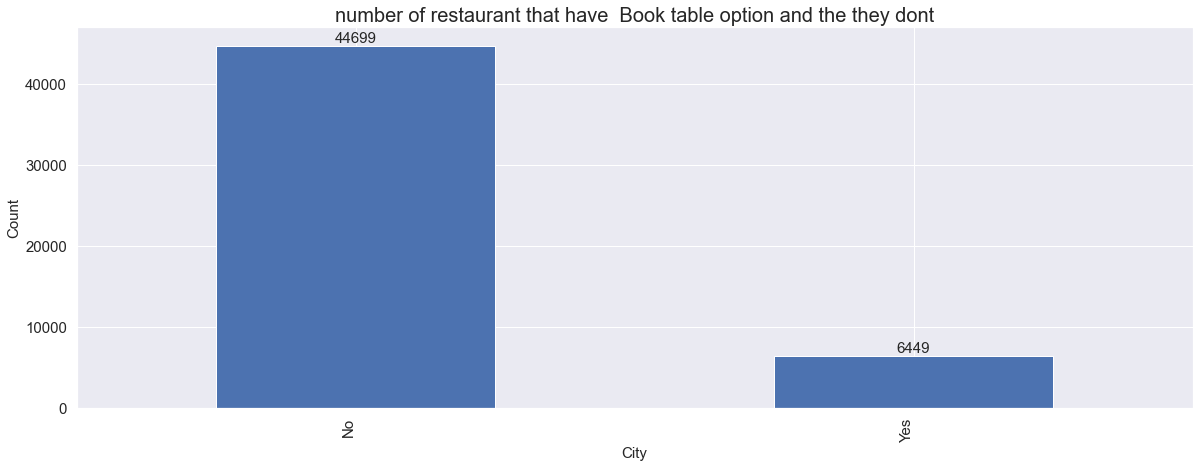

In [54]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.groupby('book_table')['name'].count().plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.title('number of restaurant that have  Book table option and the they dont', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.bar_label(ax.containers[0], fontsize=15);

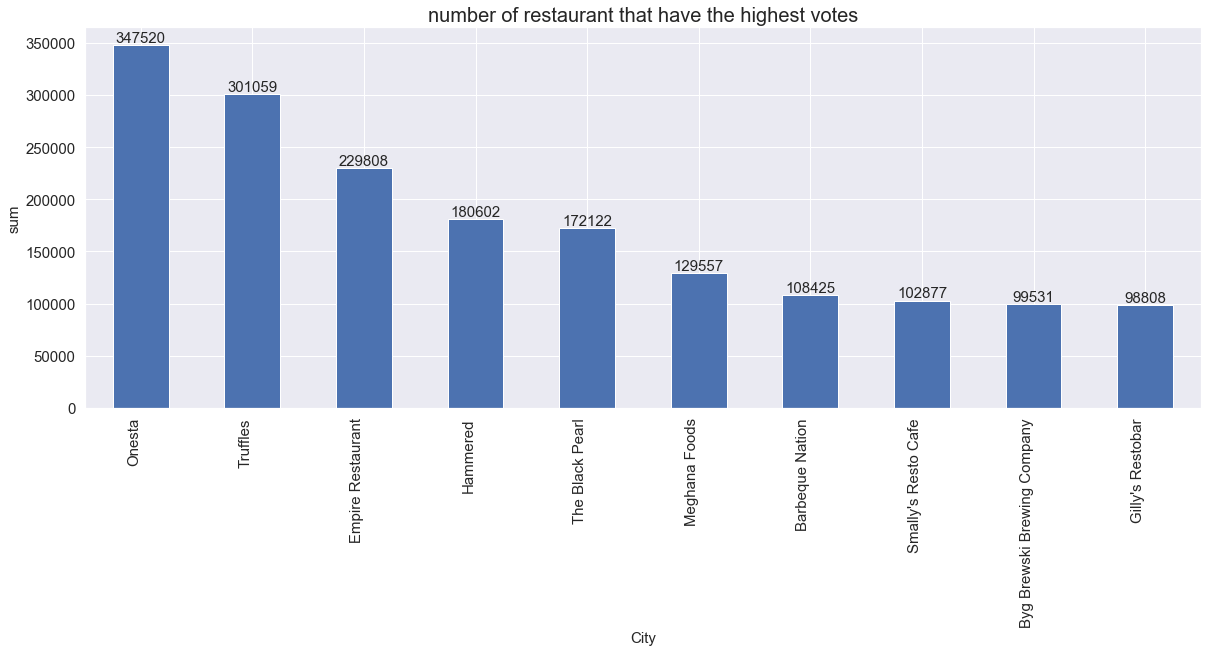

In [55]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.groupby('name')['votes'].sum().nlargest(10).plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.title('number of restaurant that have the highest votes', fontsize=20)
ax.set_ylabel('sum', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.bar_label(ax.containers[0], fontsize=15);

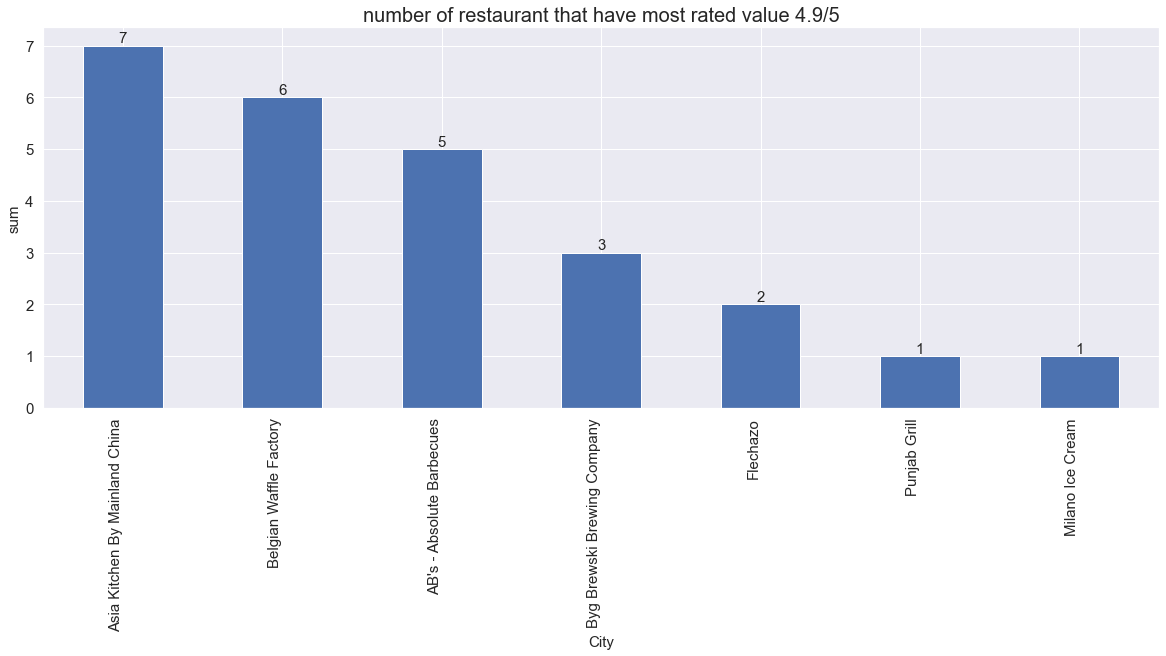

In [56]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.loc[df['new_rate'] == '4.9']['name'].value_counts().plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.title('number of restaurant that have most rated value 4.9/5', fontsize=20)
ax.set_ylabel('sum', fontsize=15)
ax.set_xlabel('City', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.bar_label(ax.containers[0], fontsize=15);

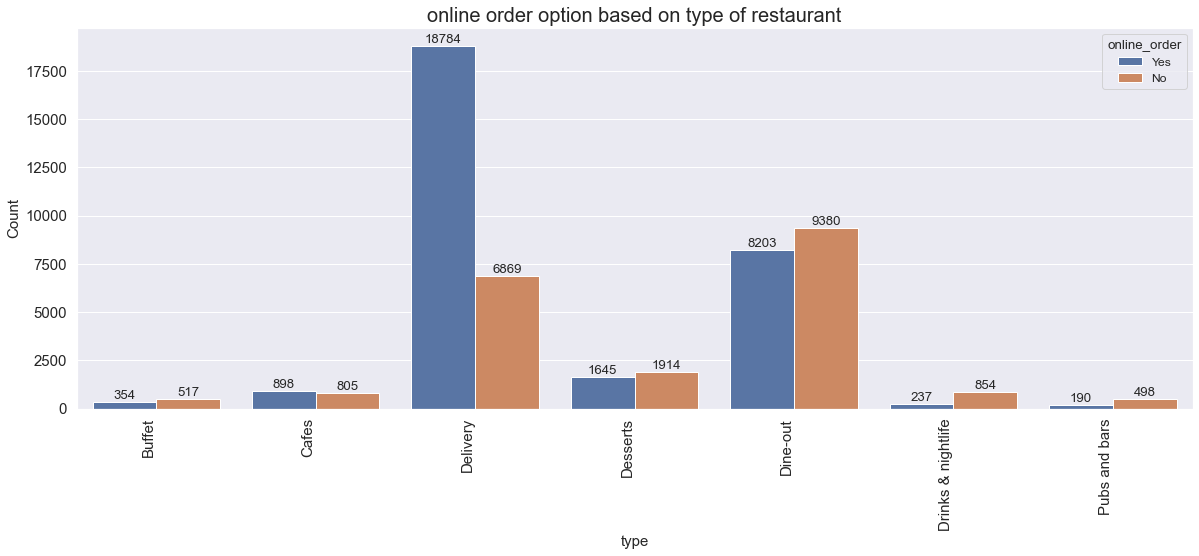

In [57]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= sns.countplot(data=df, x="type", hue="online_order")
plt.xticks(rotation=90, ha='right')
plt.title('online order option based on type of restaurant', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('type', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

for container in ax.containers:
    ax.bar_label(container)

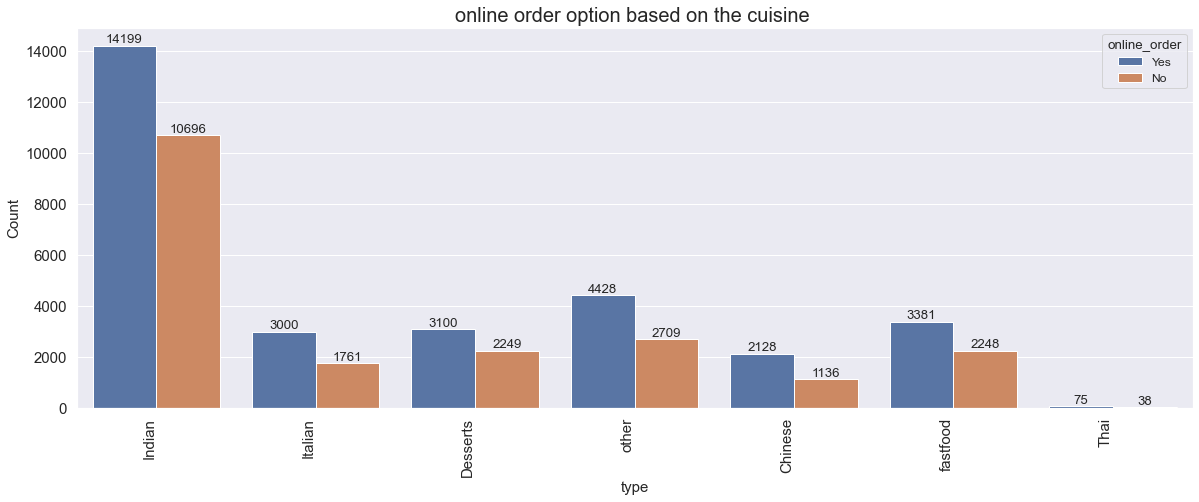

In [58]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= sns.countplot(data=df, x="cuisines", hue="online_order")
plt.xticks(rotation=90, ha='right')
plt.title('online order option based on the cuisine ', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('type', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

for container in ax.containers:
    ax.bar_label(container)

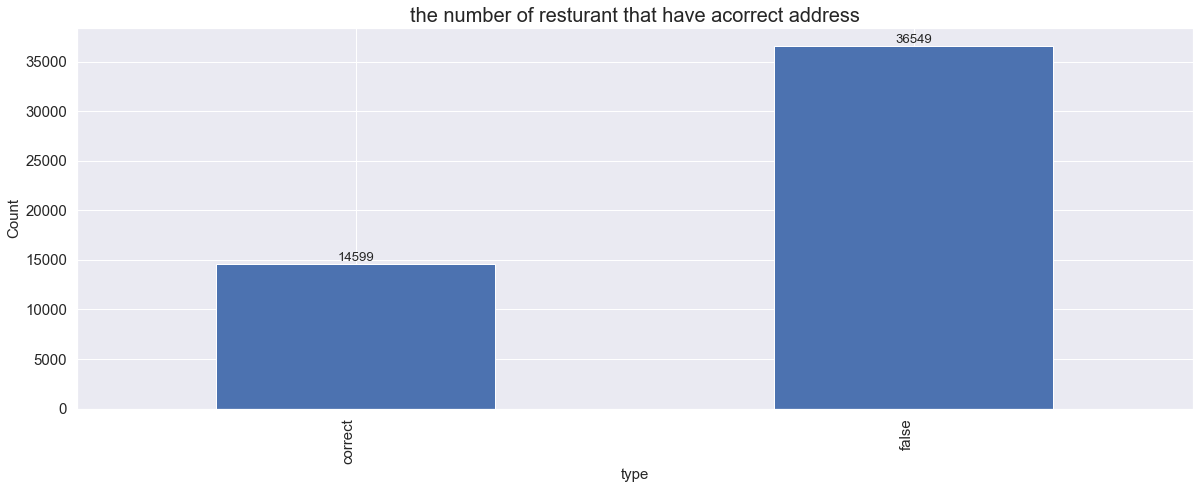

In [59]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,7))

ax= df.groupby('correct_address')['name'].count().plot(kind='bar')

plt.xticks(rotation=90, ha='right')
plt.title('the number of resturant that have acorrect address', fontsize=20)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('type', fontsize=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

for container in ax.containers:
    ax.bar_label(container)

In [60]:
# drop unuseful columns.
df.drop(['name','rate','rest_type','location','city','vote','approx_cost_for_two_people','calc_rate','new_rate','domain_name','@_sign'],
       inplace=True, axis=1)

<AxesSubplot:>

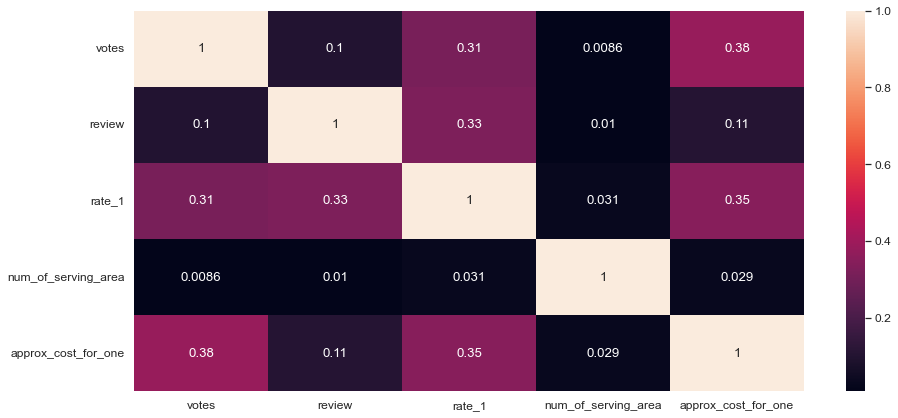

In [61]:
cor= df.corr()
sns.heatmap(cor,annot=True)

In [62]:
# rename some values.
df['type']= df['type'].replace({'Dine-out','Pubs and bars'},{'Dine_out','Bars'})

In [63]:
# rename some columns
df.rename({'rate_1':'rate'}, inplace=True, axis=1)

In [64]:
# unique values for each column.
for col in df.columns:
    print('number of unique values in {} is {}:'.format(col, df[col].nunique()))
    print('-------------------------------')
    print(df[col].unique())

number of unique values in online_order is 2:
-------------------------------
['Yes' 'No']
number of unique values in book_table is 2:
-------------------------------
['Yes' 'No']
number of unique values in votes is 2326:
-------------------------------
[ 775  787  918 ... 4957 2382  843]
number of unique values in cuisines is 7:
-------------------------------
['Indian' 'Italian' 'Desserts' 'other' 'Chinese' 'fastfood' 'Thai']
number of unique values in type is 7:
-------------------------------
['Buffet' 'Cafes' 'Delivery' 'Desserts' 'Dine_out' 'Drinks & nightlife'
 'Bars']
number of unique values in review is 5:
-------------------------------
[4 3 5 1 2]
number of unique values in rate is 2:
-------------------------------
[1 0]
number of unique values in num_of_serving_area is 2:
-------------------------------
[1 2]
number of unique values in correct_address is 2:
-------------------------------
['correct' 'false']
number of unique values in approx_cost_for_one is 69:
-----------

In [65]:
df.head()

,online_order,book_table,votes,cuisines,type,review,rate,num_of_serving_area,correct_address,approx_cost_for_one
0,Yes,Yes,775,Indian,Buffet,4,1,1,correct,400
1,Yes,No,787,Indian,Buffet,4,1,1,correct,400
2,Yes,No,918,Italian,Buffet,3,1,1,correct,400
3,No,No,88,Indian,Buffet,4,1,1,correct,150
4,No,No,166,Indian,Buffet,4,1,2,false,300


# Test Model (Base model)
> we gonna train two models one for test the and hyperparameter tuning and the othe one we gonna used in pipline and deployment

In [66]:
# taking copy from the original data.
df_train= df.copy()

In [67]:
# transform the categorical variable to dummies variable.
df_train= pd.get_dummies(df_train, columns=['cuisines','type'])

In [68]:
# caling the data and transform the other categorical variable.
sca= StandardScaler()
enc= LabelEncoder()

def encoder_(col, df):
    enc= LabelEncoder()
    df[col]= enc.fit_transform(df[col])
    return df.head()

encoder_('online_order', df_train)
encoder_('book_table', df_train)
encoder_('correct_address', df_train)

,online_order,book_table,votes,review,rate,num_of_serving_area,correct_address,approx_cost_for_one,cuisines_Chinese,cuisines_Desserts,cuisines_Indian,cuisines_Italian,cuisines_Thai,cuisines_fastfood,cuisines_other,type_Bars,type_Buffet,type_Cafes,type_Delivery,type_Desserts,type_Dine_out,type_Drinks & nightlife
0,1,1,775,4,1,1,0,400,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,1,0,787,4,1,1,0,400,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,1,0,918,3,1,1,0,400,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,0,0,88,4,1,1,0,150,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,166,4,1,2,1,300,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [69]:
# spliting the data to train and test set
x= df_train.loc[:,(df_train.columns!='rate')]
y= df_train['rate']

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42)


# after we training many models it seemes the accuracy for all models not passing 70% so we 
# gonna use (sqrt) technique to improve the corrleton between the variable and the target, it normalize the 
# data since our data is skewed distribution and stabilize the std to our data.

x_train= np.sqrt(x_train)
x_test= np.sqrt(x_test)

sca.fit(x_train)

x_train= sca.transform(x_train)
x_test= sca.transform(x_test)

# sm = SMOTE(random_state = 2)

# x_train_, y_train_= sm.fit_resample(x_train, y_train.ravel())

In [70]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(40918, 21)
(10230, 21)
(40918,)
(10230,)


In [71]:
print(sum(y_train == 0))
print(sum(y_train == 1))

20705
20213


In [72]:
x_train
# print(sum(y_train_ == 1))

array([[-1.20881474, -0.38029393,  0.4671101 , ..., -0.27284183,
        -0.72486205, -0.1489408 ],
       [ 0.82725662, -0.38029393,  0.00593723, ..., -0.27284183,
         1.37957284, -0.1489408 ],
       [-1.20881474, -0.38029393, -0.54505019, ..., -0.27284183,
         1.37957284, -0.1489408 ],
       ...,
       [-1.20881474, -0.38029393, -0.82054391, ...,  3.66512714,
        -0.72486205, -0.1489408 ],
       [ 0.82725662,  2.62954497,  2.98992048, ..., -0.27284183,
        -0.72486205, -0.1489408 ],
       [ 0.82725662,  2.62954497,  0.22989529, ..., -0.27284183,
        -0.72486205, -0.1489408 ]])

In [73]:
# train some classification models to chose one for optimization.
models={
    "RANF":RandomForestClassifier(),
    "Logi":LogisticRegression(),
    "SGD":SGDClassifier(),
    "GauNB":GaussianNB(),
    "BerNNB":BernoulliNB(),
    "LineRD":LinearDiscriminantAnalysis(),
    "QuadAN":QuadraticDiscriminantAnalysis(),
    "SVC":SVC(),
    "DecTR":DecisionTreeClassifier(),
    "KNN":KNeighborsClassifier(),
    "XGB":XGBClassifier()}

In [74]:
# we gonna loop over the models calculate the train score and the test score.
for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(x_train, y_train)
    print(f'Training Score: {model.score(x_train, y_train)}')
    print(f'Test Score: {model.score(x_test, y_test)}')
    y_pred = model.predict(x_test)
    accur= classification_report(y_test,y_pred)
    print('Classification Report is : \n', accur )
    print(f'Precision value is  : {accur.split()[19]}')
    print(f'Recall value is  : {accur.split()[20]}')
    print(f'F1 Score value is  : {accur.split()[21]}\n')
    print('----------------------------------------\n')

Using model: RANF
Training Score: 0.987755999804487
Test Score: 0.8957966764418377
Classification Report is : 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5318
           1       0.88      0.90      0.89      4912

    accuracy                           0.90     10230
   macro avg       0.90      0.90      0.90     10230
weighted avg       0.90      0.90      0.90     10230

Precision value is  : 0.90
Recall value is  : 0.90
F1 Score value is  : 0.90

----------------------------------------

Using model: Logi
Training Score: 0.822498655848282
Test Score: 0.8257086999022483
Classification Report is : 
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      5318
           1       0.84      0.78      0.81      4912

    accuracy                           0.83     10230
   macro avg       0.83      0.82      0.82     10230
weighted avg       0.83      0.83      0.83     10230

Pr

In [75]:
# since the DecisionTreeClassifier is the highest score model 
# then we gonna chosed for hyperparameter tuning using gridsearch.

model = DecisionTreeClassifier()

param_grid= {'criterion':['gini','entropy'],
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

search= GridSearchCV(model, param_grid, cv=10, n_jobs=-1).fit(x_train, y_train)
search.best_params_

{'criterion': 'entropy', 'max_depth': 70}

In [76]:
# retrain the model on the best parameter.
model= DecisionTreeClassifier(criterion= search.best_params_['criterion'],
                              max_depth= search.best_params_['max_depth'])

model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=70)

In [77]:
model.score(x_train, y_train)

0.9877804389266338

In [78]:
model.score(x_test,y_test)

0.9344086021505377

In [79]:
y_pred= model.predict(x_test)

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5318
           1       0.93      0.93      0.93      4912

    accuracy                           0.93     10230
   macro avg       0.93      0.93      0.93     10230
weighted avg       0.93      0.93      0.93     10230



# proudaction Model

In [81]:
x_a= df.loc[:,(df.columns!='rate')]
y_a= df['rate']

In [82]:
x_train_a, x_test_a, y_train_a, y_test_a= train_test_split(x_a,y_a, test_size=0.2, random_state=42)

In [83]:
# make pipline to fit the transformation and the model using pipline and ColumnTransformer.
numeric_pipline= Pipeline([('scalar',StandardScaler())])
categorical_pipeline= Pipeline([('label',OneHotEncoder(drop='first'))])
transformer= ColumnTransformer([('num',numeric_pipline,['votes','review','num_of_serving_area','approx_cost_for_one']),
                                         ('cat',categorical_pipeline,['online_order','book_table','cuisines','type','correct_address'])])

In [84]:
modelA= Pipeline([('Transformer',transformer),('Dtree',DecisionTreeClassifier(criterion= search.best_params_['criterion'],
                                                                             max_depth= search.best_params_['max_depth']))])

In [85]:
# fit the model to our data.
modelA.fit(x_train_a, y_train_a)

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  ['votes', 'review',
                                                   'num_of_serving_area',
                                                   'approx_cost_for_one']),
                                                 ('cat',
                                                  Pipeline(steps=[('label',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['online_order', 'book_table',
                                                   'cuisines', 'type',
                                                   'correct_address'])])),
                ('Dtree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=70))])

### model accuracy using some classification evaluation metrics  

In [86]:
y_pred_a= modelA.predict(x_test_a)

In [87]:
modelA.score(x_train_a,y_train_a)

0.9877804389266338

In [88]:
modelA.score(x_test_a,y_test_a)

0.9320625610948191

In [89]:
brier_score_loss(y_test_a, y_pred_a)

0.06793743890518084

In [90]:
print(classification_report(y_test_a,y_pred_a))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5318
           1       0.93      0.93      0.93      4912

    accuracy                           0.93     10230
   macro avg       0.93      0.93      0.93     10230
weighted avg       0.93      0.93      0.93     10230



In [91]:
confusion_matrix(y_test_a,y_pred_a)

array([[4955,  363],
       [ 332, 4580]], dtype=int64)

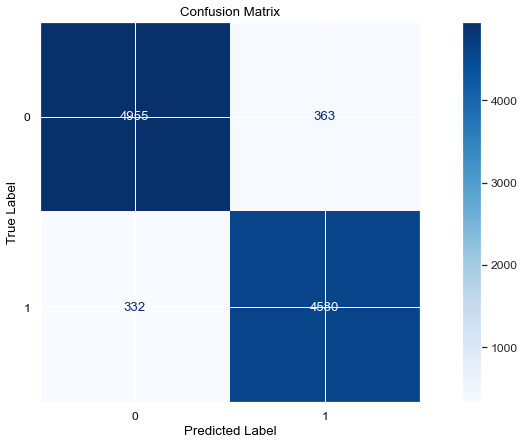

In [93]:
matrix = plot_confusion_matrix(modelA, x_test_a, y_test_a, cmap= plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color='black')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.tick_params(colors='black')
plt.tick_params(colors='black')
plt.show()

## saving the model

In [94]:
import joblib

In [95]:
joblib.dump(modelA, 'modelA.joblip')

['modelA.joblip']

In [96]:
x_a.columns

Index(['online_order', 'book_table', 'votes', 'cuisines', 'type', 'review',
       'num_of_serving_area', 'correct_address', 'approx_cost_for_one'],
      dtype='object')